# Predicting EPL Result Using Classification

## Notebook Contents:

[Objective](#Objective)  
[Data Prep/Summary](#DPS)  
[Model](#model)

<a id='Objective'></a>
### Objective:
Predict the probability of each matches results of English Premier League using past season and Pro Evolution Soccer data using classification.<br>
We train seasons from 12/13 to 17/18 to predict 18/19 season. New teams promoted on 18/19 will be ignored.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import poisson

import matplotlib.pyplot as plt
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<a id='DPS'></a>
### Data Prep/Summary:
- Pro Evloution Soccer Data (PES 14 - PES 19)
- English Premier League Stats (2012 - Present)
- English Premier League Fixtures (2012 - Present)

In [2]:
# Current season Roster Power Index(RPI) from PES Database.
# Each data is used to predict each season.
# For example, use pes14 to predict (train) 14/15 season.
# Merge PES 15 data with epl 1314 table in order to predict EPL 14/15 season.

pes_data = pd.read_csv('./Data/pes_data.csv')

In [3]:
# Past season RPIs and Match Power Index(MPI)from past season.

epl_data = pd.read_csv('./Data/epl_data.csv')[['Season', 'Team', 'H_Att', 'A_Att', 'H_Def', 'A_Def', 'CS', 'YC', 'RC']]

In [4]:
# Merge two RPIs.
# Merge PES 15 database and EPL 13/14 table.
# Train 5 merged data to predict 18/19 season.

# Add 1 to epl_data season to sync with PES data. 
# For example, we are using PES 19 data with stats from EPL 17/18(we saved this as Season = 18)
epl_data['Season'] = epl_data['Season'] + 1

pes_data = pd.merge(pes_data, epl_data, on=['Team','Season'], how='right')

In [5]:
# Load EPL fixtures.
epl_fixture = pd.read_csv('./Data/epl_fixture.csv')[['Season', 'HomeTeam', 'AwayTeam', 'FTR']]

In [6]:
# Merge all features to fixture data

def mergedata(epl_fixture):
    for i in range(len(epl_fixture)):
        season = epl_fixture.loc[i, 'Season']
        hometeam = epl_fixture.loc[i, 'HomeTeam']
        awayteam = epl_fixture.loc[i, 'AwayTeam']
        try:
            epl_fixture.loc[i, 'HtOff'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['H_Att'].values[0]
            epl_fixture.loc[i, 'HtDef'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['H_Def'].values[0]
            epl_fixture.loc[i, 'HtPesOvr'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['Ovr'].values[0]
            epl_fixture.loc[i, 'HtPesDef'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['Def'].values[0]
            epl_fixture.loc[i, 'HtPesOff'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['Fwd'].values[0]
            epl_fixture.loc[i, 'HtPesMid'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['Mid'].values[0]
            epl_fixture.loc[i, 'HtPesPhy'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['Phy'].values[0]
            epl_fixture.loc[i, 'HtPesSpd'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['Spd'].values[0]
            epl_fixture.loc[i, 'HtYC'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['YC'].values[0]
            epl_fixture.loc[i, 'HtRC'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['RC'].values[0]
            epl_fixture.loc[i, 'HtCS'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == hometeam)]['CS'].values[0]

            epl_fixture.loc[i, 'AtOff'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['A_Att'].values[0]
            epl_fixture.loc[i, 'AtDef'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['A_Def'].values[0]
            epl_fixture.loc[i, 'AtPesOvr'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['Ovr'].values[0]
            epl_fixture.loc[i, 'AtPesDef'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['Def'].values[0]
            epl_fixture.loc[i, 'AtPesOff'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['Fwd'].values[0]
            epl_fixture.loc[i, 'AtPesMid'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['Mid'].values[0]
            epl_fixture.loc[i, 'AtPesPhy'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['Phy'].values[0]
            epl_fixture.loc[i, 'AtPesSpd'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['Spd'].values[0]
            epl_fixture.loc[i, 'AtYC'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['YC'].values[0]
            epl_fixture.loc[i, 'AtRC'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['RC'].values[0]
            epl_fixture.loc[i, 'AtCS'] = pes_data[(pes_data['Season'] == season) & (pes_data['Team'] == awayteam)]['CS'].values[0]

        except IndexError:
            pass
        
    return epl_fixture

In [7]:
# Our final dataset for the classification
# drop promoted teams
mergedata(epl_fixture).dropna(inplace=True)

In [8]:
epl_fixture.head()

,Season,HomeTeam,AwayTeam,FTR,HtOff,HtDef,HtPesOvr,HtPesDef,HtPesOff,HtPesMid,...,AtDef,AtPesOvr,AtPesDef,AtPesOff,AtPesMid,AtPesPhy,AtPesSpd,AtYC,AtRC,AtCS
0,14,Arsenal,Aston Villa,A,1.587838,0.976645,84.0,84.0,82.0,85.0,...,1.385135,79.0,79.0,81.0,79.0,78.0,79.0,70.0,3.0,5.0
1,14,Liverpool,Stoke City,H,1.114865,0.679406,82.0,82.0,83.0,82.0,...,0.777027,81.0,79.0,82.0,80.0,81.0,76.0,73.0,4.0,12.0
2,14,Norwich City,Everton,D,0.844595,0.849257,79.0,80.0,80.0,79.0,...,0.777027,80.0,81.0,79.0,83.0,79.0,77.0,57.0,3.0,11.0
3,14,Sunderland,Fulham,A,0.675676,0.806794,80.0,79.0,81.0,81.0,...,1.013514,80.0,80.0,84.0,80.0,78.0,76.0,48.0,3.0,8.0
4,14,Swansea City,Manchester Utd,A,0.945946,1.104034,79.0,78.0,80.0,80.0,...,0.810811,85.0,83.0,89.0,85.0,79.0,78.0,57.0,1.0,13.0


### EDA

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.radviz' is deprecated, import 'pandas.plotting.radviz' instead.
  


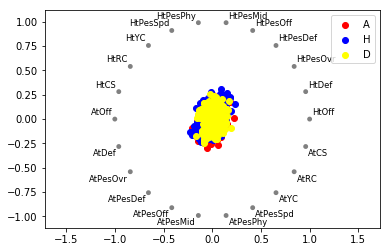

In [28]:
from pandas.tools.plotting import radviz
radviz(epl_fixture.drop(['Season','HomeTeam','AwayTeam'], axis=1), "FTR", color=['red', 'blue', 'yellow'])

<a id='model'></a>
### Model
- KNN
- Logistic Regression
- Random Forest
- Bagging Classifier
- ExtraTrees Classifier
- AdaBoost Classifier
- Gradient Boosting Classifier
- VC

In [10]:
# Divide EPL fixtures from Season 13 to 18 and Season 19 (Games played current season so far)
epl_past_fixture = epl_fixture[epl_fixture['Season'] < 19]
epl_current_fixture = epl_fixture[epl_fixture['Season'] == 19]

In [11]:
X = epl_past_fixture.drop(columns=(['HomeTeam', 'AwayTeam', 'FTR', 'Season']))
y = epl_past_fixture['FTR']

In [12]:
X.columns

Index(['HtOff', 'HtDef', 'HtPesOvr', 'HtPesDef', 'HtPesOff', 'HtPesMid',
       'HtPesPhy', 'HtPesSpd', 'HtYC', 'HtRC', 'HtCS', 'AtOff', 'AtDef',
       'AtPesOvr', 'AtPesDef', 'AtPesOff', 'AtPesMid', 'AtPesPhy', 'AtPesSpd',
       'AtYC', 'AtRC', 'AtCS'],
      dtype='object')

In [13]:
# Train test split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.33)

In [14]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
bag = BaggingClassifier(random_state=42)
etc = ExtraTreesClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
vc = VotingClassifier(estimators=[('lr', LogisticRegression()), ('knn', KNeighborsClassifier()),
                                 ('bag', BaggingClassifier(n_estimators=5)), ('etc', ExtraTreesClassifier()),
                                  ('ada', AdaBoostClassifier()), ('gbc', GradientBoostingClassifier())], voting='soft')

knn.fit(X_train, y_train)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
bag.fit(X_train, y_train)
etc.fit(X_train, y_train)
ada.fit(X_train, y_train)
gbc.fit(X_train, y_train)
vc.fit(X_train, y_train);

In [15]:
print('---- Score on Train (Past Data) ----')
print('KNN:' + str(knn.score(X_train, y_train)))
print('LR:' + str(lr.score(X_train, y_train)))
print('RF:' + str(rf.score(X_train, y_train)))
print('BAG:' + str(bag.score(X_train, y_train)))
print('ETC:' + str(etc.score(X_train, y_train)))
print('ADA:' + str(ada.score(X_train, y_train)))
print('GBC:' + str(gbc.score(X_train, y_train)))
print('VC:' + str(vc.score(X_train, y_train)))

print('---- Score on Test (Past Data)  ----')
print('KNN:' + str(knn.score(X_test, y_test)))
print('LR:' + str(lr.score(X_test, y_test)))
print('RF:' + str(rf.score(X_test, y_test)))
print('BAG:' + str(bag.score(X_test, y_test)))
print('ETC:' + str(etc.score(X_test, y_test)))
print('ADA:' + str(ada.score(X_test, y_test)))
print('GBC:' + str(gbc.score(X_test, y_test)))
print('VC:' + str(vc.score(X_test, y_test)))

---- Score on Train (Past Data) ----
KNN:0.6081229418221734
LR:0.5246981339187706
RF:0.9791437980241493
BAG:0.9780461031833151
ETC:1.0
ADA:0.58397365532382
GBC:0.7552140504939627
VC:0.9802414928649835
---- Score on Test (Past Data)  ----
KNN:0.42761692650334077
LR:0.49443207126948774
RF:0.4521158129175947
BAG:0.43875278396436523
ETC:0.44320712694877507
ADA:0.45879732739420936
GBC:0.48329621380846327
VC:0.47438752783964366


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
# Predicting current season games
cs_X = epl_current_fixture.drop(columns=(['HomeTeam', 'AwayTeam', 'FTR', 'Season']))
cs_y = epl_current_fixture['FTR']

In [17]:
ss = StandardScaler()
cs_X = ss.fit_transform(cs_X)

In [31]:
print('---- Score on Current Season ----')
print('KNN:' + str(knn.score(cs_X, cs_y)))
print('LR:' + str(lr.score(cs_X, cs_y)))
print('GBC:' + str(gbc.score(cs_X, cs_y)))

---- Score on Current Season ----
KNN:0.5238095238095238
LR:0.6031746031746031
GBC:0.5714285714285714


In [19]:
# Empty full fixture for 18/19
# Create 380 rows(games) between teams

teams = sorted(set(pd.read_csv('./Data/matchday.csv')['Team']))
fixture_1819 = pd.DataFrame(columns=['HomeTeam', 'AwayTeam'])
fixture_1819['HomeTeam'] = teams * 20
for i in range(0, 400):
     fixture_1819.loc[i, 'AwayTeam'] = teams[int(i/20)]
fixture_1819 = fixture_1819[fixture_1819['HomeTeam'] != fixture_1819['AwayTeam']].reset_index(drop=True)
fixture_1819['Season'] = 19

In [20]:
mergedata(fixture_1819).dropna(inplace=True)

In [21]:
len(fixture_1819)

272

In [22]:
fixture_X = fixture_1819.drop(columns=(['HomeTeam', 'AwayTeam', 'Season']))

In [23]:
fixture_1819.loc[:, 'Result'] = lr.predict(fixture_X)
fixture_1819.reset_index(inplace=True, drop=True)

In [24]:
standing = pd.DataFrame(columns=(['Team', 'W', 'D', 'L', 'PTS', 'Rank']))
standing['Team'] = teams
standing[['PTS', 'W', 'L', 'D', 'Rank']]= 0

In [25]:
for i in range(len(fixture_1819)):
    if fixture_1819.loc[i, 'Result'] == 'H':
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'HomeTeam'], 'PTS'] += 3
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'HomeTeam'], 'W'] += 1
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'AwayTeam'], 'L'] += 1

    if fixture_1819.loc[i, 'Result'] == 'A':
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'AwayTeam'], 'PTS'] += 3
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'AwayTeam'], 'W'] += 1
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'HomeTeam'], 'L'] += 1
        
    if fixture_1819.loc[i, 'Result'] == 'D':
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'HomeTeam'], 'PTS'] += 1
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'AwayTeam'], 'PTS'] += 1
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'AwayTeam'], 'D'] += 1
        standing.loc[standing['Team'] == fixture_1819.loc[i, 'HomeTeam'], 'D'] += 1


In [26]:
standing = standing.sort_values('PTS', ascending=False)
standing = standing.reset_index(drop=True)
for i in range(len(standing)):
    standing.loc[i, 'Rank'] = i + 1
standing = standing.set_index('Rank')

In [27]:
standing

,Team,W,D,L,PTS
Rank,,,,,
1,Liverpool,28,0,4,84
2,Arsenal,27,0,5,81
3,Manchester Utd,27,0,5,81
4,Chelsea,27,0,5,81
5,Manchester City,27,0,5,81
6,Tottenham,25,0,7,75
7,Everton,19,0,13,57
8,West Ham Utd,15,0,17,45
9,Leicester City,13,0,19,39
